In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 98% !important }<style>"))

# Analysis

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [4]:
ble = read_ble("../Data/ble.csv")
pin = read_pin("../Data/pin.csv")
testPin = read_pin("../Data/testPin.csv")

In [5]:
data = read_data("../Data/rssi_2.csv")
data.shape

All beacons: ['0117C55D14E4']
Selecting all


(63707, 19)

In [6]:
data[scanners] = min_max_scaling(data[scanners])

In [7]:
test = read_data("../Data/testRssi_2.csv")
test.shape

All beacons: ['0117C55D14E4']
Selecting all


(18771, 19)

In [8]:
test[scanners] = min_max_scaling(test[scanners])

## Train Validation Split

In [9]:
train, validation = train_validation_split(data)

In [10]:
train.shape

(50965, 19)

In [11]:
validation.shape

(12742, 19)

In [12]:
train.sort_values("time", inplace=True)
validation.sort_values("time", inplace=True)
test.sort_values("time", inplace=True)

In [13]:
rolling_win = 30
train_rolled = train.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
validation_rolled = validation.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
test_rolled = test.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()

In [14]:
train_rolled

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.440000,0.316667,NaN,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,NaN,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.300000,NaN,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.288889,NaN,0.466667,0.383333,0.454167,0.266667,NaN,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,NaN,0.308333,NaN,0.466667,0.383333,0.454167,0.283333,NaN,0.55


## Imputation
1. Forward fill

In [15]:
train_imputed = train_rolled.set_index("location").groupby("location").ffill()
train_imputed.reset_index(inplace=True)

In [16]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


In [17]:
validation_imputed = validation_rolled.set_index("location").groupby("location").ffill()
validation_imputed.reset_index(inplace=True)

In [18]:
test_imputed = test_rolled.set_index("location").groupby("location").ffill()
test_imputed.reset_index(inplace=True)

In [19]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,E6D9D20DD197,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C
0,V1_10,24997,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,V1_10,24999,0.466667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
2,V1_10,25000,0.466667,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
3,V1_10,25001,0.466667,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
4,V1_10,25002,0.483333,0.400000,NaN,0.566667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.440000,0.316667,0.1,0.55
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.300000,0.1,0.55
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.288889,0.15,0.466667,0.383333,0.454167,0.266667,0.1,0.55
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.25,0.216667,0.275,0.6375,0.066667,0.308333,0.15,0.466667,0.383333,0.454167,0.283333,0.1,0.55


## Change Location to Coordinates

In [20]:
train_imputed["X"] = train_imputed["location"].apply(lambda x: pin[x]["X"])
train_imputed["Y"] = train_imputed["location"].apply(lambda x: pin[x]["Y"])

In [21]:
validation_imputed["X"] = validation_imputed["location"].apply(lambda x: pin[x]["X"])
validation_imputed["Y"] = validation_imputed["location"].apply(lambda x: pin[x]["Y"])

In [22]:
test_imputed["X"] = test_imputed["location"].apply(lambda x: testPin[x]["X"])
test_imputed["Y"] = test_imputed["location"].apply(lambda x: testPin[x]["Y"])

## Linear Imputation

In [23]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

In [24]:
linear_impute(train_imputed)
linear_impute(validation_imputed)
linear_impute(test_imputed)

In [25]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,24997,0.466667,0.377514,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.577052,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
1,V1_10,24999,0.466667,0.377514,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
2,V1_10,25000,0.466667,0.400000,0.341782,0.571869,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
3,V1_10,25001,0.466667,0.400000,0.341782,0.566667,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
4,V1_10,25002,0.483333,0.400000,0.341782,0.566667,0.455598,0.312956,0.270723,0.460916,...,0.335279,0.170158,0.496903,0.666667,0.412474,0.353866,0.070892,0.449889,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50960,V1_9,31037,0.350000,0.216667,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.440000,0.316667,0.100000,0.550000,8.17867,5.28213
50961,V1_9,31039,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.300000,0.100000,0.550000,8.17867,5.28213
50962,V1_9,31040,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.288889,0.150000,0.466667,0.383333,0.454167,0.266667,0.100000,0.550000,8.17867,5.28213
50963,V1_9,31041,0.350000,0.238889,0.316667,0.491667,0.250000,0.216667,0.275000,0.637500,...,0.308333,0.150000,0.466667,0.383333,0.454167,0.283333,0.100000,0.550000,8.17867,5.28213


## Model Training

In [26]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [27]:
optimizer = tf.keras.optimizers.Adam(0.0001)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 1000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss')
]

model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=(17,)),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 50965 samples, validate on 18771 samples
Epoch 1/1000
50965/50965 [==============================] - 2s 36us/sample - loss: 158.3348 - mae: 10.4944 - mse: 158.3347 - val_loss: 85.6080 - val_mae: 7.2476 - val_mse: 85.6080
Epoch 2/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 44.6188 - mae: 4.9407 - mse: 44.6188 - val_loss: 27.3505 - val_mae: 4.3017 - val_mse: 27.3505
Epoch 3/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 25.3909 - mae: 4.0342 - mse: 25.3909 - val_loss: 16.3728 - val_mae: 3.4711 - val_mse: 16.3728
Epoch 4/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 14.8888 - mae: 3.1672 - mse: 14.8888 - val_loss: 9.3218 - val_mae: 2.5818 - val_mse: 9.3218
Epoch 5/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 8.7423 - mae: 2.4225 - mse: 8.7423 - val_loss: 7.0410 - val_mae: 2.1304 - val_mse: 7.0410
Epoch 6/1000
50965/50965 [==============================] - 1s 28us/

Epoch 48/1000
50965/50965 [==============================] - 2s 30us/sample - loss: 1.4118 - mae: 0.9262 - mse: 1.4118 - val_loss: 2.6331 - val_mae: 1.3168 - val_mse: 2.6331
Epoch 49/1000
50965/50965 [==============================] - 2s 30us/sample - loss: 1.4064 - mae: 0.9243 - mse: 1.4064 - val_loss: 2.6444 - val_mae: 1.3165 - val_mse: 2.6444
Epoch 50/1000
50965/50965 [==============================] - 2s 30us/sample - loss: 1.4008 - mae: 0.9222 - mse: 1.4008 - val_loss: 2.6251 - val_mae: 1.3146 - val_mse: 2.6251
Epoch 51/1000
50965/50965 [==============================] - 2s 30us/sample - loss: 1.3935 - mae: 0.9195 - mse: 1.3935 - val_loss: 2.6255 - val_mae: 1.3111 - val_mse: 2.6255
Epoch 52/1000
50965/50965 [==============================] - 2s 31us/sample - loss: 1.3840 - mae: 0.9162 - mse: 1.3840 - val_loss: 2.6069 - val_mae: 1.3030 - val_mse: 2.6069
Epoch 53/1000
50965/50965 [==============================] - 2s 31us/sample - loss: 1.3743 - mae: 0.9125 - mse: 1.3743 - val_loss:

Epoch 142/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0305 - mae: 0.7730 - mse: 1.0305 - val_loss: 2.3926 - val_mae: 1.2473 - val_mse: 2.3926
Epoch 143/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0287 - mae: 0.7724 - mse: 1.0287 - val_loss: 2.4277 - val_mae: 1.2541 - val_mse: 2.4277
Epoch 144/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0273 - mae: 0.7717 - mse: 1.0273 - val_loss: 2.3985 - val_mae: 1.2503 - val_mse: 2.3985
Epoch 145/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0253 - mae: 0.7709 - mse: 1.0253 - val_loss: 2.4173 - val_mae: 1.2550 - val_mse: 2.4173
Epoch 146/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0234 - mae: 0.7701 - mse: 1.0234 - val_loss: 2.4296 - val_mae: 1.2582 - val_mse: 2.4296
Epoch 147/1000
50965/50965 [==============================] - 1s 28us/sample - loss: 1.0217 - mae: 0.7693 - mse: 1.0217 - val

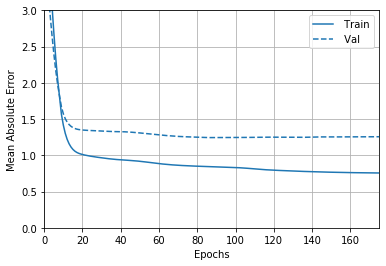

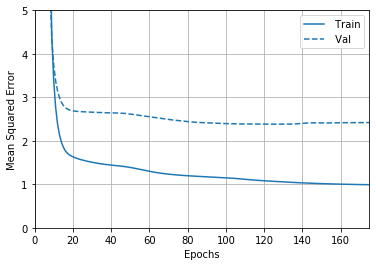

In [30]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [31]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

12742/1 - 0s - loss: 0.6127 - mae: 0.7640 - mse: 1.0197
Validation loss: 1.0196657396690416
Mean absolute error: 0.76395416
Mean squared error: 1.0196658
Average distance error: 1.2087588125088244


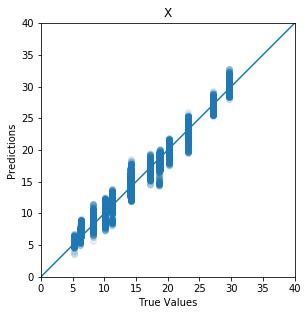

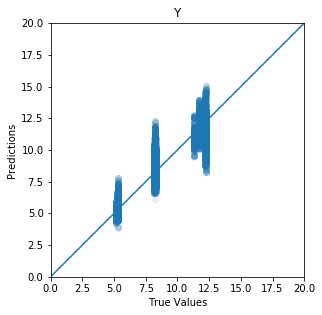

In [32]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

## Model Testing

18771/1 - 0s - loss: 2.4139 - mae: 1.2604 - mse: 2.4368
Test loss: 2.436816177220319
Mean absolute error: 1.2603551
Mean squared error: 2.4368155
Average distance error: 1.9650047336584546


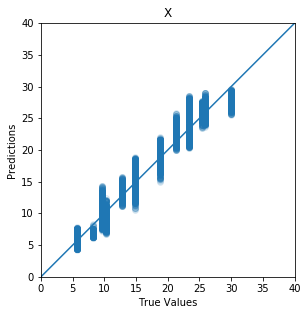

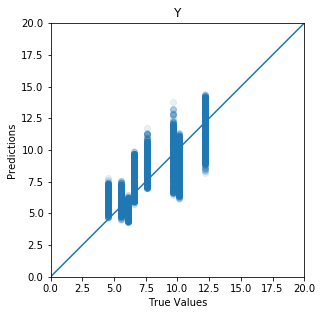

In [33]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

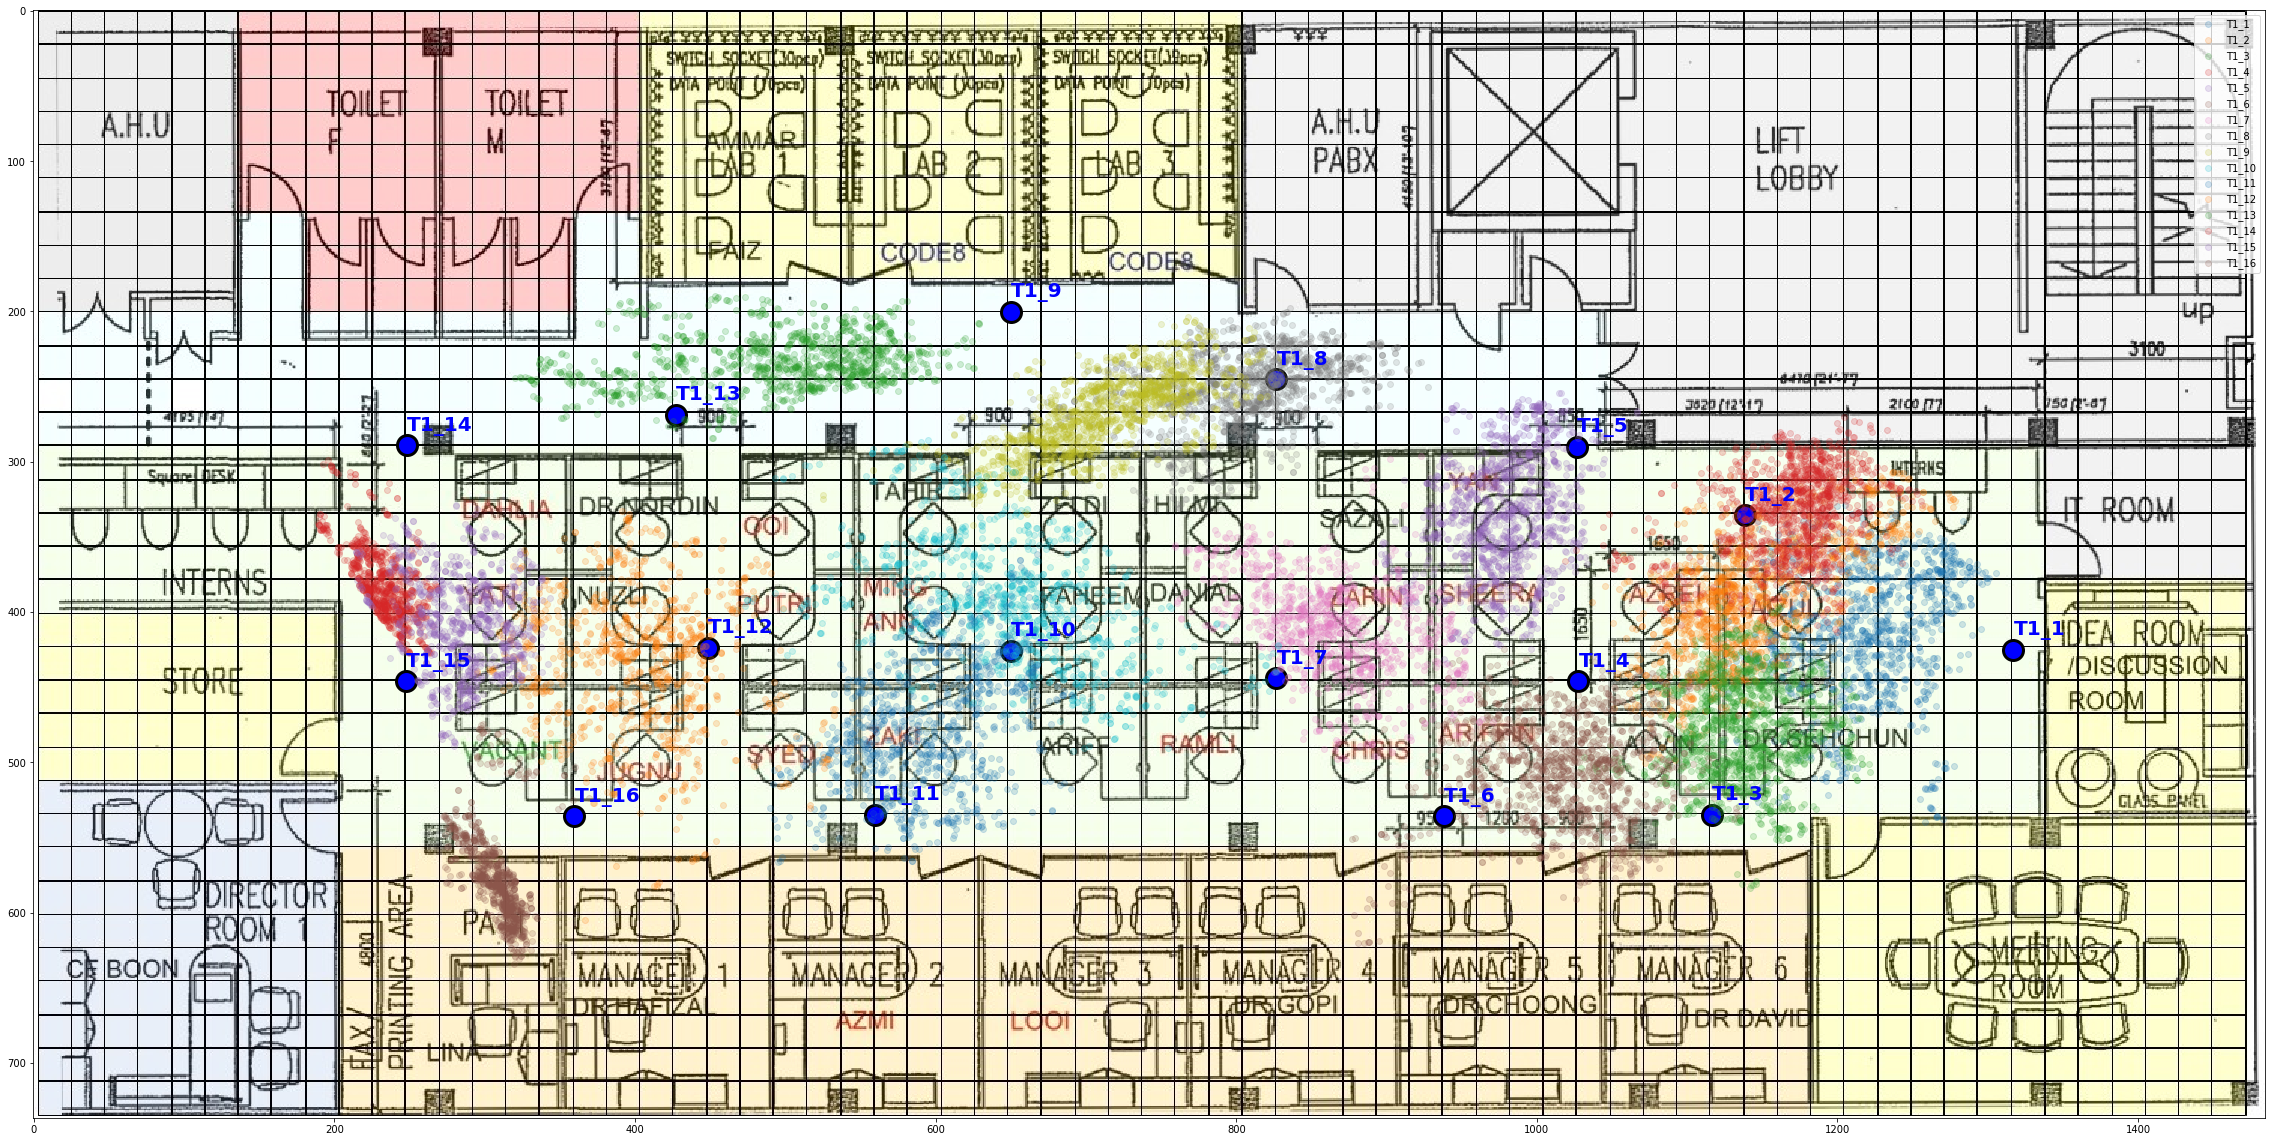

In [34]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()

In [35]:
model.save('../Models/MLP.h5')